In [1]:
import random
import matplotlib.pyplot as plt
import math
import time
import itertools

In [2]:
random.seed(1)
habitable_width, habitable_length = 100, 100
probability_of_genome_shuffle = 0.05
probability_of_genome_mutation = 0.05

In [3]:
#initializing probability by choosing (probability_of_genome_shuffle*100) numbers, so whenever one of these numbers is chosen during reproduction, mutation takes place
numbers_to_shuffle = []
for i in range(int(probability_of_genome_shuffle*100)):
    temp = random.randint(1, 100)
    while(temp in numbers_to_shuffle):
        temp = random.randint(1, 100)
    numbers_to_shuffle.append(temp)
    
numbers_to_mutate = []
for i in range(int(probability_of_genome_mutation*100)):
    temp = random.randint(1, 100)
    while(temp in numbers_to_mutate):
        temp = random.randint(1, 100)
    numbers_to_mutate.append(temp)

In [4]:
class Location:
    __slots__ = ('x', 'y')
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__ (self, other):
        return (self.x == other.x) and (self.y == other.y)
        
    def __hash__ (self):
        return hash((self.x, self.y))

In [5]:
def random_house_location():
    #naming the side on x-axis '1' and the following sides similarly in clockwise direction
    chosen_side = random.randint(1, 4)
    match chosen_side:
        case 1:
            return Location(x = random.randrange(0, habitable_length), y = 0)
        case 2:
            return Location(x = habitable_length, y = random.randrange(1, habitable_width))
        case 3:
            return Location(x = random.randrange(0, habitable_length - 1), y = habitable_width)
        case 4:
            return Location(x = 0, y = random.randrange(1, habitable_width - 1))

In [6]:
class Genome:
    __slots__ = ('genome', 'fitness')
    def __init__(
        self,
        genome: str,
        fitness = None
    ):
        self.genome = genome
        self.fitness = (genome.count('A') * 4) + (genome.count('C') * 3) + (genome.count('G') * 2) + (genome.count('T'))
        #therefore, organisms with more number of 'A' are fitter

    def mutate(self):
        #attempt to change a character in genome string
        char_list = list(self.genome)
        char_list[random.randint(0, 3)] = random.choice(['A', 'C', 'G', 'T'])
        self.genome = "".join(char_list)
        #update fitness based on new genome string
        self.fitness = (self.genome.count('A') * 4) + (self.genome.count('C') * 3) + (self.genome.count('G') * 2) + (self.genome.count('T'))
    
    def shuffle(self):
        x = self.genome
        letters = [x[_] for _ in range(len(x))] #split genome string
        new_order_of_letters = []
        not_used = [_ for _ in range(len(x))] #letters with no position allotted
        for _ in range(len(x)):
            new_order_of_letters.append(random.choice(not_used))
            not_used.remove(new_order_of_letters[-1])
        shuffled_string = ""
        for i in range(len(x)):
            shuffled_string = shuffled_string + (letters[new_order_of_letters[i]])
        self.genome = shuffled_string

In [7]:
class Organism:
    __slots__ = ('location', 'health', 'energy', 'mass', 'genome', 'energy_required_to_survive', 'surplus_energy_to_reproduce')
    def __init__(
        self,
        location: Location,
        health: float = 1,
        energy: float = 5,
        mass: float = 1,
        genome: Genome = Genome(genome = "ATGC"),
        energy_required_to_survive: float = 10,
        surplus_energy_to_reproduce: float = 10,
    ):
        self.health = health
        self.energy = energy
        self.mass = mass
        self.location = location
        self.genome = genome
        self.energy_required_to_survive = (energy_required_to_survive) - (genome.fitness/16) #current amount of energy required, if excess by an amount delta than reproduce
        self.surplus_energy_to_reproduce = (surplus_energy_to_reproduce) - (genome.fitness/16) # if energy surplus == this amount, then reproduce
    
    def isAlive(self):
        return self.health > 0
    
    def speed(self):
        return math.sqrt(2*self.energy/self.mass)
    
    def move(self):
        self.location.x += random.choice([-1, 0, 1])
        self.location.y += random.choice([-1, 0, 1])

In [8]:
class Food:
    __slots__ = ('energy', 'location')
    def __init__(
        self,
        location: Location,
        energy: float,
    ):
        self.energy = energy
        self.location = location

In [9]:
def airdrop_food(food_quantity):
    food_data = [Food(energy = random.randrange(1, 5), location = Location(random.randrange(2, habitable_length - 1), random.randrange(2, habitable_width - 1))) for _ in range(food_quantity)]
    food_map = {food.location : food for food in food_data}
    return food_map

In [10]:
def play_game(being_1, being_2):
    #returns 1 if being_1 wins
    return random.choice([0, 0.5, 1])

In [13]:
def simulate(food_airdropped_per_day, total_organisms, max_days):

    #initialization
    organisms = [Organism(location = random_house_location()) for _ in range(total_organisms // 2)]
    organisms.extend([Organism(location = random_house_location(), genome = Genome(genome = "ATGG")) for _ in range(total_organisms - total_organisms // 2)])
    genome_count_history = {}
    for combination in itertools.product("ATGC", repeat = 4):
        genome_count_history["".join(combination)] = [0 for _ in range(max_days + 1)]
    genome_count_history["ATGC"][0] = total_organisms // 2
    genome_count_history["ATGG"][0] = total_organisms - total_organisms // 2
    organisms_alive = total_organisms
    organism_count_history = [organisms_alive]
    food_map = airdrop_food(food_airdropped_per_day)
    time_of_day_in_sec = 0
    days_passed = 0

    while days_passed < max_days:

        stop_clock = False
        while not stop_clock:
            time_of_day_in_sec += 1
            being_to_delete = []

            for being in organisms:      #
                if being.isAlive():      # Move all beings
                    being.move()         #

            i_finds_food = False
            i_meets_j = -1
            for i in range(len(organisms)):

                if organisms[i].isAlive():
                    i_meets_j = -1 #value of j, -1 means it has not met anyone
                    i_finds_food = False

                    for j in range(i+1, len(organisms)):
                        if not organisms[j].isAlive():
                            continue
                        if organisms[i].location == organisms[j].location:
                            i_meets_j = j
                            break

                    if organisms[i].location in food_map:
                        i_finds_food = True

                    if i_finds_food and not i_meets_j == -1:
                        #distribute food among i and j based on the result of a game between i and j
                        #for game, 1 indicates winning, 0 for losing and 0.5 for a draw
                        i_wins = play_game(organisms[i], organisms[i_meets_j])
                        organisms[i].energy += i_wins * food_map[organisms[i].location].energy
                        organisms[i_meets_j].energy += (1 - i_wins) * food_map[organisms[i_meets_j].location].energy
                        del food_map[organisms[i].location]
                    elif i_finds_food and i_meets_j == -1:
                        organisms[i].energy += food_map[organisms[i].location].energy
                    elif not i_finds_food and not i_meets_j == -1:
                        i_wins = play_game(organisms[i], organisms[i_meets_j])
                        #loser dies
                        if i_wins == 1:
                            being_to_delete.append(i_meets_j)
                            organisms[i_meets_j].health = 0
                            organisms_alive -= 1
                        elif i_wins == 0:
                            being_to_delete.append(i)
                            organisms[i].health = 0
                            organisms_alive -= 1
                        #else both live

            being_to_delete.sort(reverse = True)
            for i in being_to_delete:
                del organisms[i]
            being_to_delete = []

            if time_of_day_in_sec == 86400: #60*60*24,i.e., a day has passed, now check who has the energy to survive 
                days_passed += 1
                time_of_day_in_sec = 0
                stop_clock = True
                for i in range(len(organisms)):
                    if organisms[i].isAlive():
                        if organisms[i].energy >= organisms[i].energy_required_to_survive:
                            # being survives
                            organisms[i].health -= (organisms[i].genome.fitness)/16 #organism's health depletes as it ages
                            organisms[i].energy -= organisms[i].energy_required_to_survive

                            if organisms[i].energy >= organisms[i].surplus_energy_to_reproduce:
                                #being reproduces
                                new_being = Organism(
                                    location = random_house_location(),
                                    genome = organisms[i].genome, # inherits genome from parent
                                    health = 1,
                                    energy = 5,
                                    mass = organisms[i].mass,
                                    energy_required_to_survive = organisms[i].energy_required_to_survive,
                                    surplus_energy_to_reproduce = organisms[i].surplus_energy_to_reproduce,
                                )
                                                                
                                if random.randint(1, 100) in numbers_to_shuffle:
                                    #shuffle genome
                                    new_being.genome.shuffle()
                                if random.randint(1, 100) in numbers_to_mutate:
                                    #mutate
                                    new_being.genome.mutate()
                                    new_being.energy_required_to_survive = (new_being.energy_required_to_survive) - (new_being.genome.fitness/16) 
                                    new_being.surplus_energy_to_reproduce = (new_being.surplus_energy_to_reproduce) - (new_being.genome.fitness/16)
                                organisms.append(new_being)
                                organisms_alive += 1
                                organisms[i].energy -= organisms[i].surplus_energy_to_reproduce
                            #being is still alive, therefore, it goes back to the village
                            organisms[i].location = random_house_location()
                        else:
                            #being dies                          
                            being_to_delete.append(i)
                            organisms_alive -= 1

                being_to_delete.sort(reverse = True)
                for i in being_to_delete:
                    del organisms[i]

                for being in organisms:
                    genome_count_history[being.genome.genome][days_passed] += 1

                organism_count_history.append(organisms_alive)
                print(f"End of Day {days_passed}/{max_days}: {organisms_alive} organisms alive", end = '\r')
    return organism_count_history, genome_count_history

In [15]:
organism_count_history, genome_count_history = simulate(food_airdropped_per_day = 100, total_organisms = 300, max_days = 100)

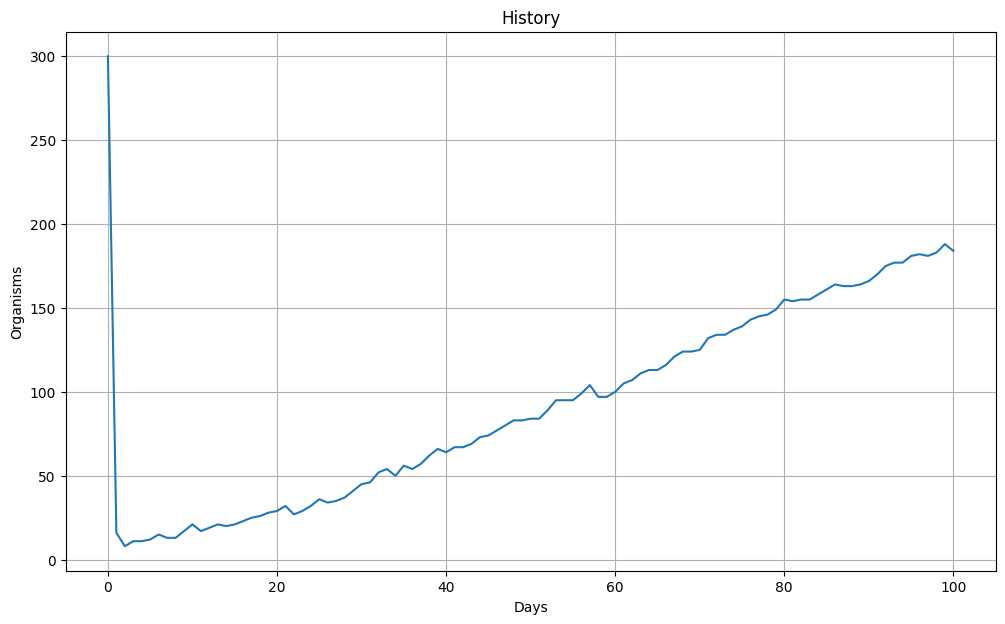

In [16]:
plt.figure(figsize = (12, 7))
plt.plot(organism_count_history)
plt.title("History")
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Organisms')
plt.show()

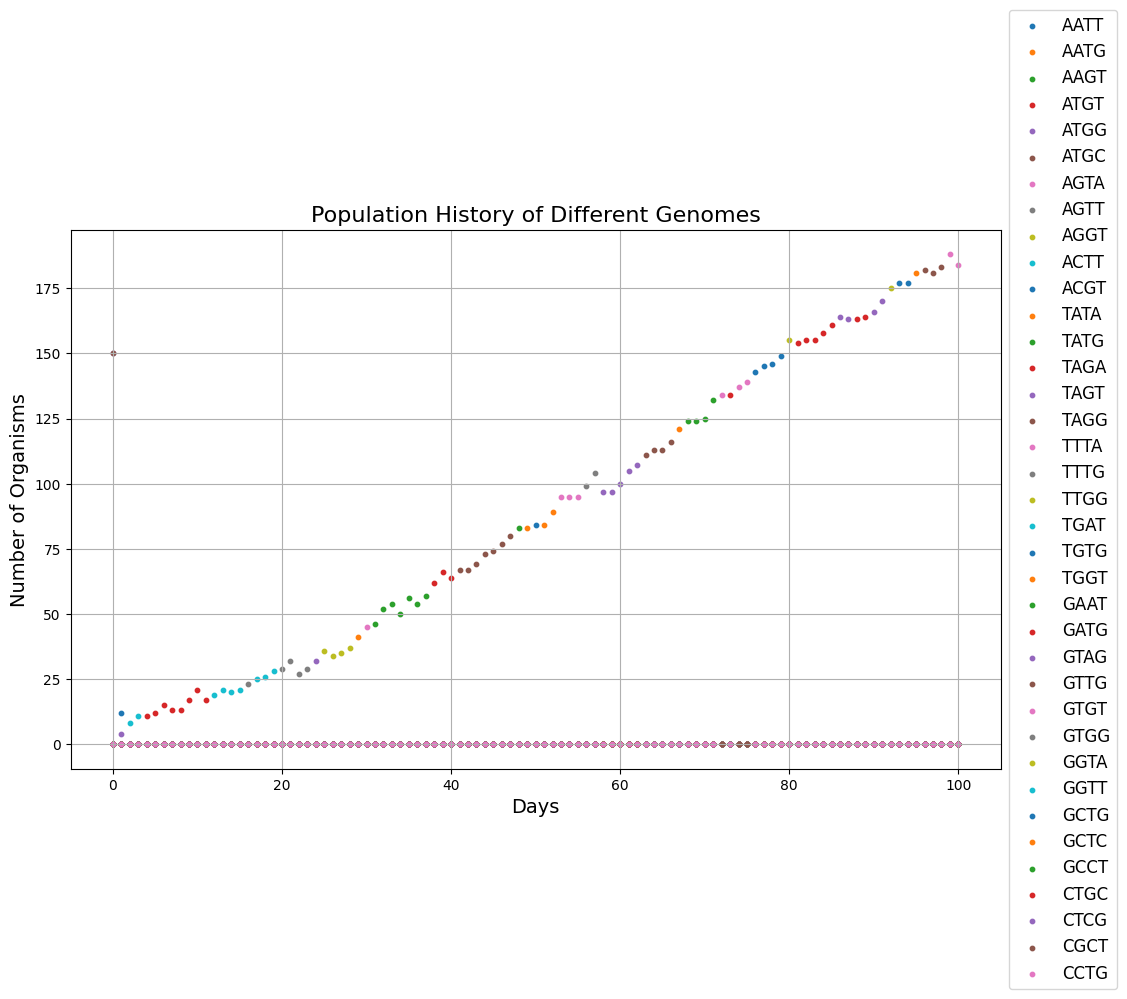

In [18]:
# Plotting the population history of different genomes with dots
plt.figure(figsize=(12, 7))
for genome, history in genome_count_history.items():
    if sum(history) > 0:  # Only plot genomes that have non-zero counts at some point
        days = range(len(history))
        plt.scatter(days, history, label=genome, s=10)  # Use scatter plot for individual dots

plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Organisms', fontsize=14)
plt.title('Population History of Different Genomes', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
